In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Load an image in grayscale
img = cv2.imread('a01-CHU-l.jpg')

In [17]:
#cv2.imshow('image', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [18]:
resized_img = cv2.resize(img, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
cv2.imshow('resized_img', resized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
img_norm = resized_img / 255.0

# Display original and normalized images
cv2.imshow('Original Image', resized_img)
cv2.imshow('Normalized Image', img_norm)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
resized_img.shape

(582, 720, 3)

In [11]:
import random
import numpy as np

# Define the size of the patch to be cropped
crop_size = 64

# Get the dimensions of the input image
height, width= img_norm.shape

# Randomly select the top-left corner of the crop
x = random.randint(0, width - crop_size)
y = random.randint(0, height - crop_size)

# Extract the patch
cropped_img = img_norm[y:y+crop_size, x:x+crop_size]


In [14]:
cv2.imshow('immg',cropped_img)

In [21]:

def find_largest_connected_component_area(mask, connectivity=8):
    """
    Find the largest connected component area froma mask image.
    ----
    Args:
        mask: 2D array, 0 for background and 1 for foreground.
        connectivity: int, scalar, chose 4-connectivity or 8.
    Returns:
        output: int, 2D array, the largest connected component area.
    """
    labels, stats = cv2.connectedComponentsWithStats(mask, connectivity)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA]) 
    output = np.uint8(labels == largest_label)
    
    return output


def get_fov(img, size=512, threshold=0.05):
    """
    Get the field of view from an fundus image.
    ----
    Args:
        img: uint8, 2D array, sugested be the red channel of a fundus image.
        size: int, scalar, the image size to be process in the procedure, 
              set it samller than the original size to make it faster.
        threshold: float (0-1), scalar, threshold to determine the foreground mask.
    Returns:
        mask: int (0 or 1), 2D array, the final mask.
    """
    img_shape = img.shape
    if img_shape[0] > size:
        img = cv2.resize(img, (size, size))
    mask = np.uint8((img / 255.0) > threshold)
    if np.sum(mask) == 0:
        print('Warning: None Foreground Detected')
    else:
        mask = find_largest_connected_component_area(mask)
    if img_shape[0] > size:
        mask = cv2.resize(mask, (img_shape[1], img_shape[0]))
    mask = np.uint8(mask)

    return mask


def rotate_image(image, angle):
    """
    Rotate an image.
    ----
    Args:
        image: uint8, 2D numpy array range from 0 to 255, the input image
        angle: float, scalar, the rotation angle 
    Returns:
        result: unit8, 2D array, the rotated image
    """
    image_center = tuple(np.array(image.shape[1::-1]) // 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1])
    
    return result


def morphological_transform(image, inverse=True, max_length=21, degree_num=8):
    """
    Apply Morphological transform on an image.
    ----
    Args:
        image: uint8, 2D numpy array range from 0 to 255, the input image
        inverse: bool, scalar, determine if to inverse the image intensity
        degree_num: int, scalar, number of degrees to apply to morphological transform
    Returns:
        tophat_sum: float, 2D array, the transformed image.
    """
    
    line = np.zeros((max_length, max_length)).astype(np.uint8)
    line[max_length // 2, :] = 1

    tophat_sum = np.zeros(image.shape).astype(np.uint16)
    for degree in np.arange(0, 181, 180 / degree_num):
        line_rotate = (rotate_image(line, degree))
        if inverse:
            tophat = cv2.morphologyEx(255 - image.copy(), cv2.MORPH_TOPHAT, line_rotate)
        else:
            tophat = cv2.morphologyEx(image.copy(), cv2.MORPH_TOPHAT, line_rotate)
        tophat_sum = tophat_sum + tophat
    
    tophat_sum = cv2.normalize(tophat_sum, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX)
    tophat_sum = np.uint8(tophat_sum)
        
    return tophat_sum


def apply_vessel_aug(image, order='RGB'):
    """
    Apply vessel augmentation on an fundus image.
    ----
    Args:
        image: uint8, 3D array in RGB order, the original image.
    Returns:
        aug_image: uint8, 3D array in RGB order, the transformed image.
    """
    if order == 'RGB':
        red_data = image[:, :, 0]
    elif order == 'BGR':
        red_data = image[:, :, 2]
    else:
        assert False, print('Only support RBG or BGR image format.')
    
    green_data = image[:, :, 1]
    fundus_mask = get_fov(red_data)
    vessel_map = morphological_transform(green_data)
    vessel_map = vessel_map * fundus_mask
    vessel_map = cv2.GaussianBlur(vessel_map, ksize=(3, 3), sigmaX=0, sigmaY=0)
    # vessel_map = cv2.GaussianBlur(vessel_map, ksize=(5, 5), sigmaX=0, sigmaY=0)
    vessel_map[vessel_map > 204] = 204
    vessel_map = np.repeat(vessel_map[:, :, np.newaxis], 3, axis=2)
    random_decay = np.random.uniform(0, 1, 3)
    for i in range(3):
        vessel_map[:, :, i] = vessel_map[:, :, i] * random_decay[i]

    amp = np.random.uniform(0, 1, 1)
    aug_image = image.astype(float) * (1 - vessel_map / 255) + vessel_map * amp
    aug_image[aug_image > 255] = 255

    return np.uint8(aug_image)
    

def random_vessel_augmentation(image, prob=0.5, order='RGB'):
    """
    Channel-wise random vessel augmentation.
    """
    rand_num = np.random.uniform(0, 1)
    if rand_num > prob:
        image = apply_vessel_aug(image, order)
        
    return image


def random_gamma_correction(image, gamma=3, order='RGB'):
    """
    Channel-wise random gamma correction in the RGB color space.
    ----
    Args:
        image: uint8, 3D array in RGB order, the original image.
        gamma: maximum value of gamma for gamma corretion.
    Returns:
        image: uint8, 3D array in RGB order, the transformed image.
    """
    rds1 = np.random.uniform(1, gamma, 3)
    rds2 = np.random.uniform(0, 1, 3) < 0.5

    for i in range(3):
        if rds2[i]:
            rds1[i] = 1 / rds1[i]
            
    trans_image = np.power(image / 255.0, rds1)
    trans_image = trans_image * 255

    if order == 'RGB':
        red_data = image[:, :, 0]
    elif order == 'BGR':
        red_data = image[:, :, 2]
    else:
        assert False, print('Only support RBG or BGR image format.')
    
    fundus_mask = get_fov(red_data)
    trans_image = trans_image * fundus_mask[:, :, None]
    
    return np.uint8(trans_image)

Text(0.5, 1.0, 'With channel-wise random gamma correction')

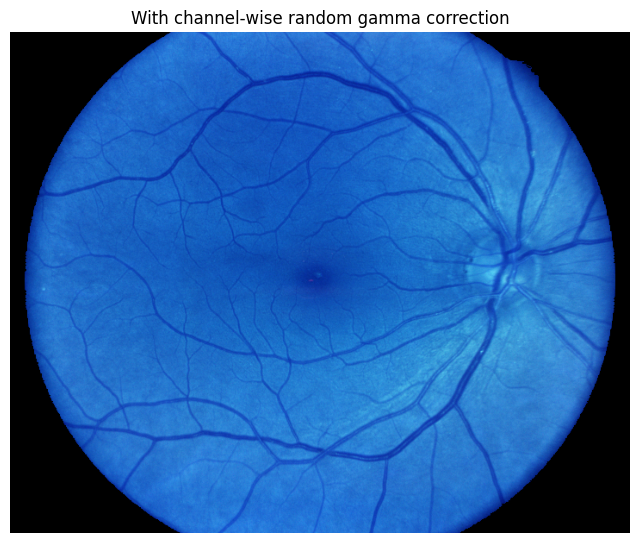

In [22]:

image_g = random_gamma_correction(resized_img)

# Visualize the demo image.
plt.figure(figsize=(8, 8))
plt.imshow(image_g)
plt.axis('off')
plt.title('With channel-wise random gamma correction')


Text(0.5, 1.0, 'With channel-wise random vessel augmentation')

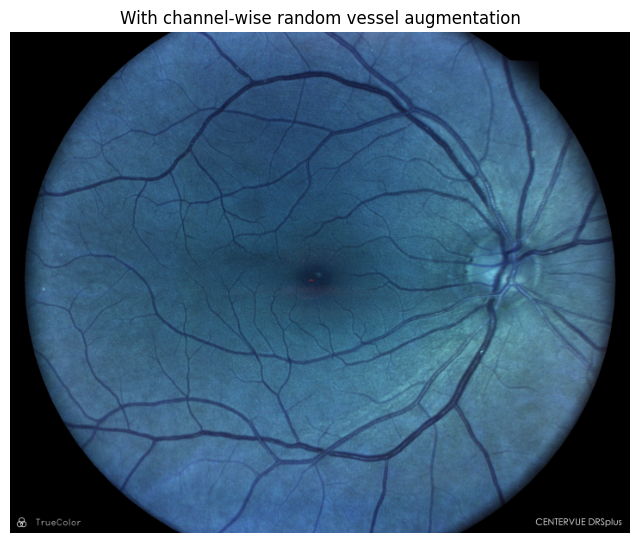

In [23]:
image_v = random_vessel_augmentation(resized_img)

# Visualize the demo image.
plt.figure(figsize=(8, 8))
plt.imshow(image_v)
plt.axis('off')
plt.title('With channel-wise random vessel augmentation')

In [25]:
#   Copyright (c) 2019 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Demo for robust vessel segmentation.
Note: The vessel segmentation model used here is trained with two novel data augmentation methods, 
namely, channel-wise random gamma correction and channel-wise random vessel augmentation.
"""
import cv2
import numpy as np
#import paddle.fluid as fluid


def resize_img(img, max_size=640):
    """
    Reisze the input image. 
    """
    img_height = img.shape[0]
    img_width = img.shape[1]
    max_axis = max(img_height, img_width)
    if max_axis > max_size:
        if img_height > img_width:
            img = cv2.resize(img, (int(img.shape[1] / img.shape[0] * max_size), max_size))
        else:
            img = cv2.resize(img, (max_size, int(img.shape[0] / img.shape[1] * max_size)))

    return img


def padding_img(img, size=640, padding_value=[127.5, 127.5, 127.5]):
    """
    Padding the input image.
    """
    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = max(size - img_height, 0)
    pad_width = max(size - img_width, 0)
    if (pad_height > 0 or pad_width > 0):
        img = cv2.copyMakeBorder(
            img,
            0,
            pad_height,
            0,
            pad_width,
            cv2.BORDER_CONSTANT,
            value=padding_value)
    else:
        raise Exception(
                "padding size({},{}) must large than img size({},{})."
                .format(size, size, img_width, img_height))
    
    return img


class VesselSegmentation(object):
    """
    Segment vessel mask from ori fundus photography imgage.
    Change states: self.vessel_segmentation_mask, i indicates vessel and 0 otherwise.
                   self.vessel_masked_img, the mask imge
    SWE: sunxu02
    """

    def __init__(self, 
                 dirname, 
                 params_filename, 
                 img_mean=[127.5, 127.5, 127.5], 
                 img_std=[127.5, 127.5, 127.5], 
                 use_cuda=True, 
                 final_size=640, 
                 vessel_thresh=0.5,
                 vessel_color=[255, 255, 255]):
        # initialize parameters to load model
        self.use_cuda = use_cuda
        self.dirname = dirname
        self.params_filename = params_filename
        self._load_model()
        # initialize parameters for image preprocessing
        self.img_mean = img_mean
        self.img_std = img_std
        self.final_size = final_size
        # initialize parameters for image postprocessing
        self.vessel_thresh = vessel_thresh
        self.vessel_color = vessel_color

    def _load_model(self):
        paddle_place = fluid.CUDAPlace(0) if self.use_cuda else fluid.CPUPlace()
        self.paddle_exe = fluid.Executor(paddle_place)

        self.vs_scope = fluid.core.Scope()
        with fluid.scope_guard(self.vs_scope):
            [self.vs_net_paddle, self. vs_feed_names, self.vs_targets] = fluid.io.load_inference_model(
                dirname=self.dirname,
                executor=self.paddle_exe,
                params_filename=self.params_filename)

    def _preprocess(self):
        # format the image shape
        self.ori_shape = ori_img.shape
        img = resize_img(self.ori_img.copy(), self.final_size)
        self.valid_shape = img.shape
        img = padding_img(img, size=self.final_size, padding_value=self.img_mean)
        # normalize
        img = (img - self.img_mean) / self.img_std
        
        self.model_input = np.transpose(img, (2, 0, 1)).astype(np.float32)

    def _infer(self):
        model_input = np.expand_dims(self.model_input, 0)
        with fluid.scope_guard(self.vs_scope):
            output = self.paddle_exe.run(self.vs_net_paddle,
                                         feed={self.vs_feed_names[0]: model_input},
                                         fetch_list=self.vs_targets)
        self.vessel_mask = np.array(output[0][0][1])

    def _postprocess(self):
        # extractt the vessel mask and convert it to the original size
        vessel_mask = self.vessel_mask[:self.valid_shape[0], :self.valid_shape[1]]
        vessel_mask = cv2.resize(vessel_mask, (self.ori_shape[1], self.ori_shape[0]))
        # get the binary mask
        vessel_mask = np.uint8(vessel_mask > self.vessel_thresh)
        # masked the original image
        masked_img = self.ori_img.copy()
        masked_img[vessel_mask==1] = self.vessel_color
        # save the results
        self.vessel_segmentation_mask = vessel_mask
        self.vessel_masked_img = masked_img

    def __call__(self, img):
        self.ori_img = img.copy()
        self._preprocess()
        self._infer()
        self._postprocess()
        return self.vessel_segmentation_mask, self.vessel_masked_img


In [ ]:


if __name__ == '__main__':

    ori_img_file = 'demo.jpg'
    dirname = 'pdl_assets'
    params_file_name = 'pdl_assets/__params__'

    vs_model = VesselSegmentation(dirname, params_file_name)
    ori_img = cv2.imread(ori_img_file)
    
    _, vessel_masked_img = vs_model(ori_img)
    cv2.imwrite('masked_img.png', vessel_masked_img)